In [1]:
import pandas as pd
import matplotlib.pyplot as plt


def read_fasta(infile):
    with open(infile, "r") as file:
        identifier = None
        sequence = []
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if identifier is not None:
                    yield identifier, "".join(sequence)
                identifier = line[1:]
                sequence = []
            else:
                sequence.append(line)

        if identifier is not None:
            yield identifier, "".join(sequence)


def write_fasta(identifier, sequence, outfile, line_length=60):
    print(f">{identifier}", file=outfile)
    formatted_sequence = "\n".join(
        [sequence[i : i + line_length] for i in range(0, len(sequence), line_length)]
    )
    print(formatted_sequence, file=outfile)

/tmp/ipykernel_1979932/237409897.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd
df = pd.read_csv('complete.tsv', sep='\t')

/tmp/ipykernel_1979932/3615597987.py:2: DtypeWarning: Columns (6,7,8,10,11,12,13,55,98,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complete.tsv', sep='\t')


In [3]:
df['EPI.VIRUS_VARIANT'] = df['EPI.VIRUS_VARIANT'].replace(['-nicht erhoben-', '-nicht ermittelbar-', 'keine VOC'], '-andere/sonstige-')
df['SEQUENCE.DATE_OF_SAMPLING'] = pd.to_datetime(df['SEQUENCE.DATE_OF_SAMPLING']).fillna('2000-01-01')
df['year_month'] = df['SEQUENCE.DATE_OF_SAMPLING'].dt.year.astype(str) + '-' + df['SEQUENCE.DATE_OF_SAMPLING'].dt.month.astype(str).str.zfill(2)
start_date = "2020-01"
end_date = "2023-10"
df = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]


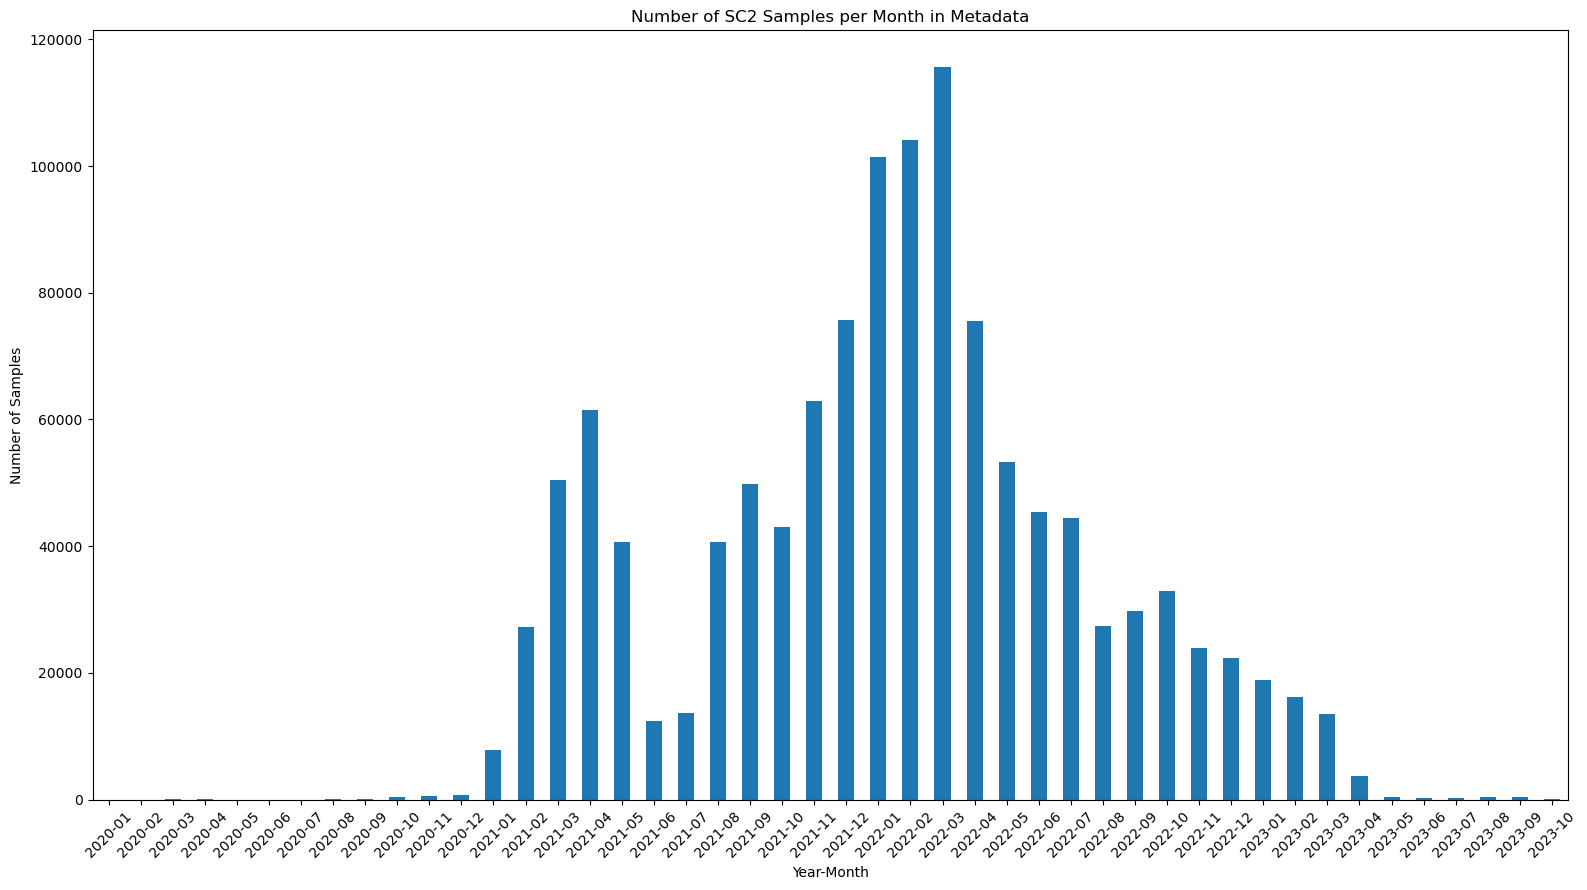

In [4]:
year_month_counts = df['year_month'].value_counts()
year_month_counts = year_month_counts.sort_index()
plt.figure(figsize=(16,9))
year_month_counts.plot(kind='bar')
plt.xlabel('Year-Month')
plt.ylabel('Number of Samples')
plt.title('Number of SC2 Samples per Month in Metadata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

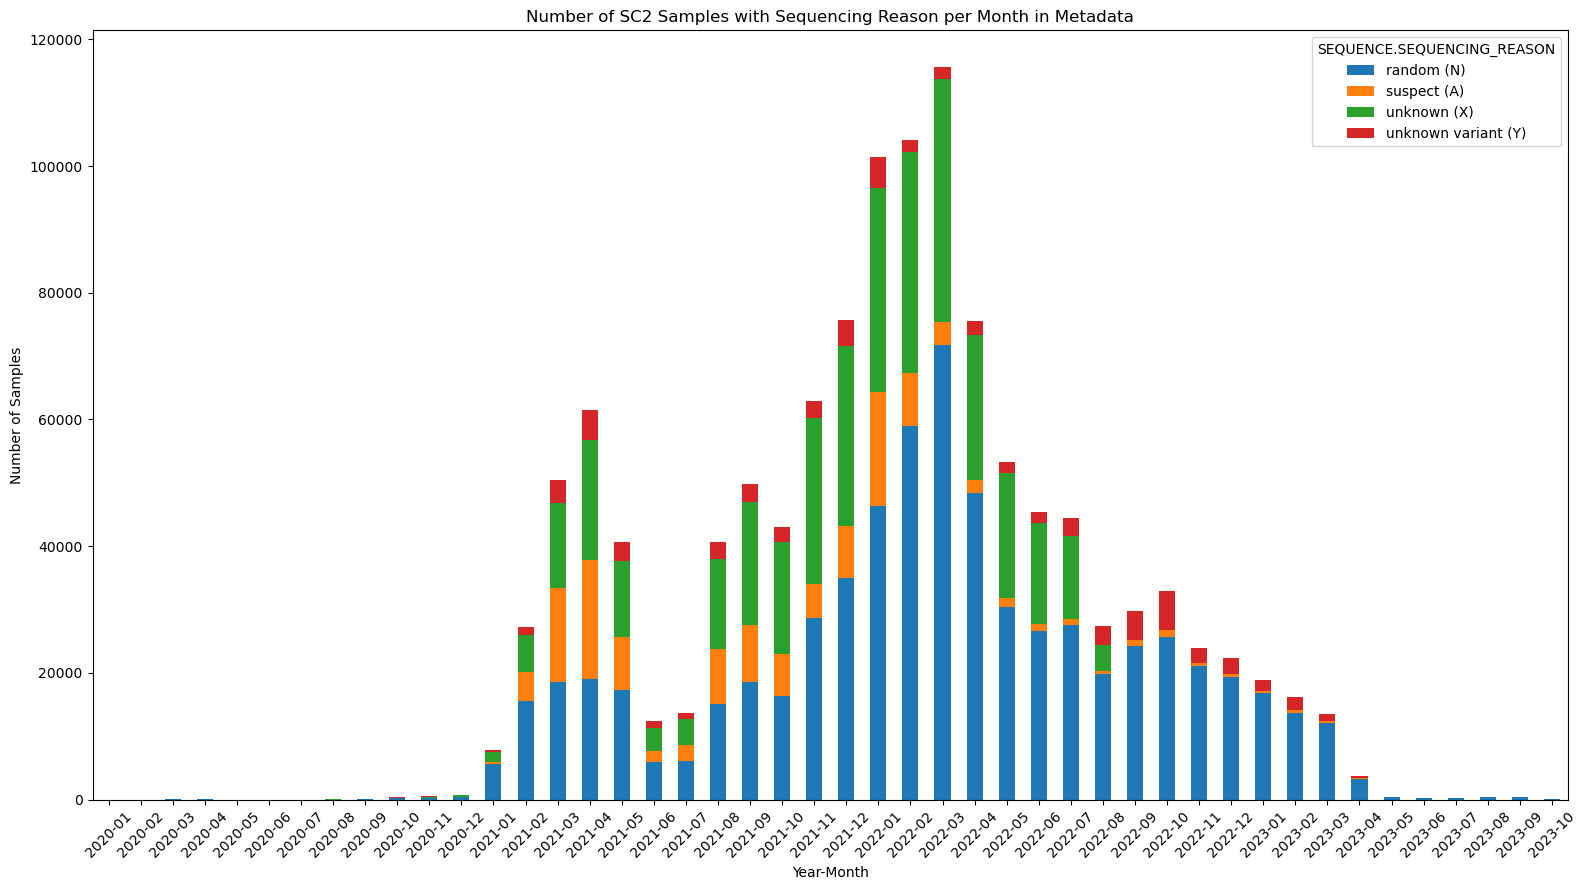

In [5]:
replace_dict = {
    'N': 'random (N)',
    'X': 'unknown (X)',
    'A': 'suspect (A)',
    'Y': 'unknown variant (Y)'
}
df.loc[:, 'SEQUENCE.SEQUENCING_REASON'] = df['SEQUENCE.SEQUENCING_REASON'].replace(replace_dict)
grouped = df.groupby(['year_month', 'SEQUENCE.SEQUENCING_REASON']).size().unstack(fill_value=0)
grouped = grouped.sort_index()
plt.figure(figsize=(16,9))
grouped.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year-Month')
plt.ylabel('Number of Samples')
plt.title('Number of SC2 Samples with Sequencing Reason per Month in Metadata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

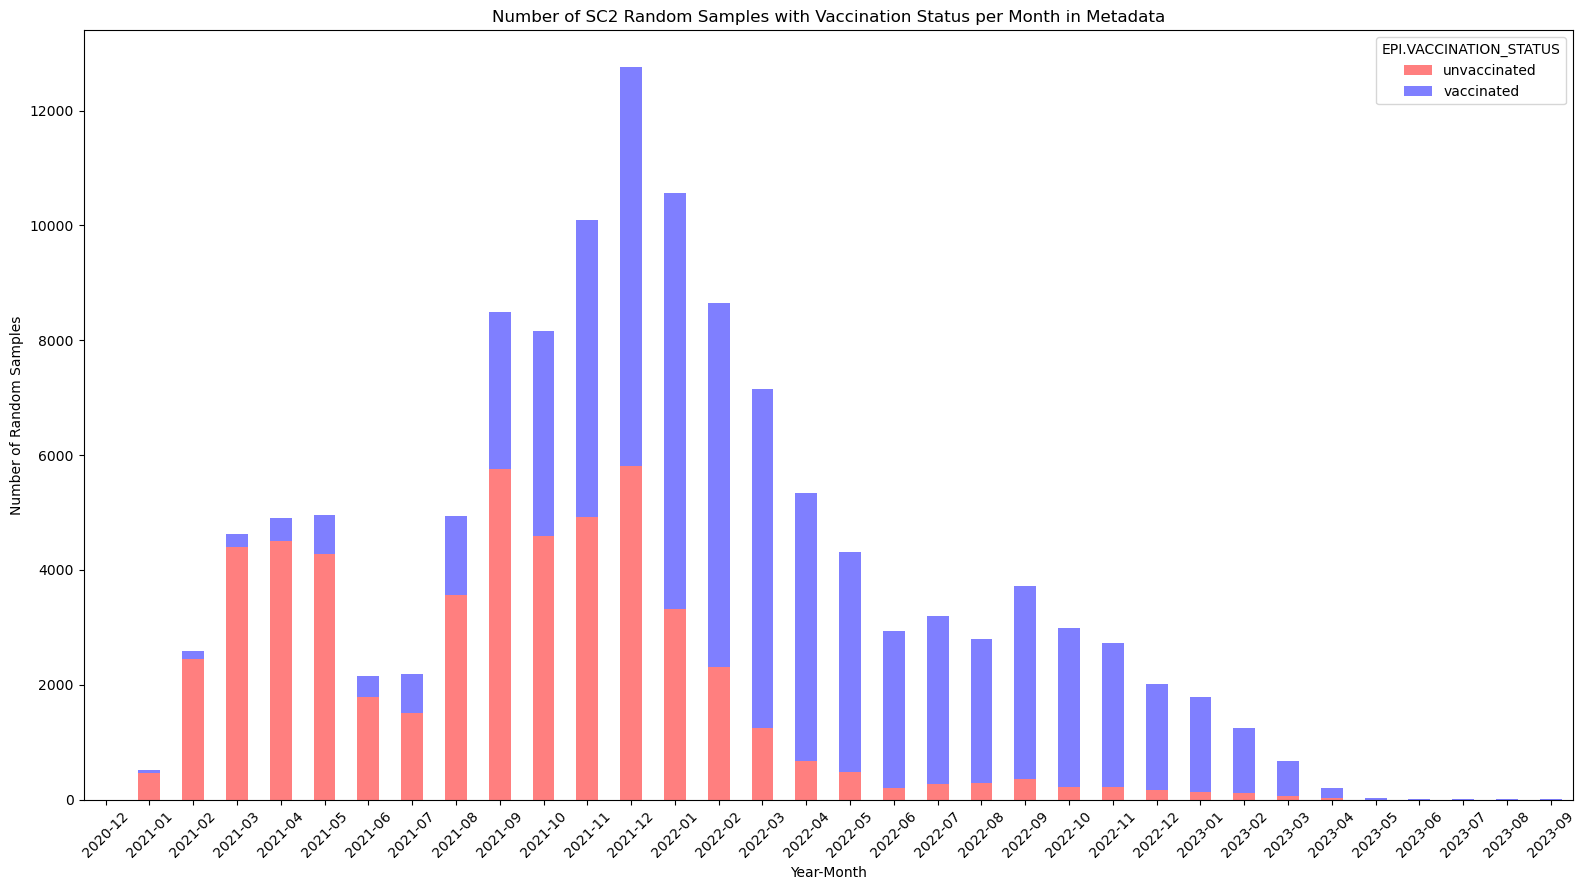

In [6]:
start_date = "2020-12"
end_date = "2023-10"
df = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
df = df[df['SEQUENCE.SEQUENCING_REASON'] == 'random (N)']
replace_dict = {'Ja': 'vaccinated', 'Nein': 'unvaccinated'}
df['EPI.VACCINATION_STATUS'] = df['EPI.VACCINATION_STATUS'].replace(replace_dict)
df['EPI.VACCINATION_STATUS']
df = df[df['EPI.VACCINATION_STATUS'].isin(['vaccinated', 'unvaccinated'])]
grouped = df.groupby(['year_month', 'EPI.VACCINATION_STATUS']).size().unstack(fill_value=0)
plt.figure(figsize=(16,9))
colors = ['red', 'blue']
grouped.plot(kind='bar', stacked=True, color=colors, alpha=0.5, ax=plt.gca())
plt.xlabel('Year-Month')
plt.ylabel('Number of Random Samples')
plt.title('Number of SC2 Random Samples with Vaccination Status per Month in Metadata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('test.png', format='png')
plt.show()


In [7]:
# target_month = '2021-08'
# vaccination_status = 'vaccinated'
# seq_ids = df[(df['year_month'] == target_month) & (df['EPI.VACCINATION_STATUS'] == vaccination_status)]['SEQUENCE.ID'].tolist()

# with open(f'input_fasta/{target_month}_{vaccination_status}_allvariants.fasta', 'w') as outfile:
#     for identifier, seq in read_fasta('complete.fasta'):
#         if identifier in seq_ids:
#             write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [8]:
pangolin_df = pd.read_csv('lineage_report.csv', usecols=['taxon', 'lineage', 'scorpio_call'])
reassigned_lineages_df = pd.merge(df, pangolin_df, left_on='SEQUENCE.ID', right_on='taxon')
reassigned_lineages_df.groupby(['scorpio_call', 'year_month', 'EPI.VACCINATION_STATUS']).size().unstack(fill_value=0)

EPI.VACCINATION_STATUS                    unvaccinated  vaccinated
scorpio_call                  year_month                          
Alpha (B.1.1.7-like)          2021-08               10           0
                              2021-09                1           1
Delta (AY.4-like)             2021-08              292         112
                              2021-09              561         279
                              2021-10              442         334
                              2021-11              537         625
                              2021-12              607         537
                              2022-01               72          45
                              2022-02                2           0
Delta (AY.4.2-like)           2021-08                9           9
                              2021-09               26          11
                              2021-10               68          31
                              2021-11               87         104
                              2021-12              157         149
                              2022-01               22          13
Delta (B.1.617.2-like)        2021-08             3240        1267
                              2021-09             5174        2426
                              2021-10             4089        3188
                              2021-11             4300        4415
                              2021-12             4586        4320
                              2022-01              645         492
                              2022-02               11           7
                              2022-03                3           0
Delta (B.1.617.2-like) +K417N 2021-08                3           0
                              2021-11                2           0
                              2021-12                3           1
                              2022-01                1           1
Mu (B.1.621-like)             2021-08                1           1
                              2021-09                1           2
Omicron (BA.1-like)           2021-11                0          15
                              2021-12              408        1790
                              2022-01             2324        6085
                              2022-02             1535        4113
                              2022-03              254        1154
Omicron (BA.2-like)           2021-12                1           9
                              2022-01              174         382
                              2022-02              717        2109
                              2022-03              985        4678
Omicron (BA.3-like)           2022-02                0           5
                              2022-03                0           1
Omicron (BA.5-like)           2021-12                2          13
                              2022-01                3          43
                              2022-03                0           1
Omicron (Unassigned)          2021-12                4          29
                              2022-01               20          70
                              2022-02               47          85
                              2022-03                6          63
Omicron (XBB-like)            2021-12                0           1
                              2022-01                0           2
Probable Omicron (Unassigned) 2021-12               25          79
                              2022-01               38          92
                              2022-02                1           9
                              2022-03                0           3

In [9]:
pangolin_df = pd.read_csv('lineage_report.csv', usecols=['taxon', 'lineage', 'scorpio_call'])
reassigned_lineages_df = pd.merge(df, pangolin_df, left_on='SEQUENCE.ID', right_on='taxon')
reassigned_lineages_df.groupby(['scorpio_call','EPI.VACCINATION_STATUS']).size().unstack(fill_value=0)

EPI.VACCINATION_STATUS,unvaccinated,vaccinated
scorpio_call,,
Alpha (B.1.1.7-like),11,1
Delta (AY.4-like),2513,1932
Delta (AY.4.2-like),369,317
Delta (B.1.617.2-like),22048,16115
Delta (B.1.617.2-like) +K417N,9,2
Mu (B.1.621-like),2,3
Omicron (BA.1-like),4521,13157
Omicron (BA.2-like),1877,7178
Omicron (BA.3-like),0,6


In [10]:
# import re
# variant = "Delta (B.1.617.2-like)"
# variant_simplified = re.sub('[^0-9a-zA-Z]+', '', variant)
# target_month = '2022-01'
# vaccination_status = 'vaccinated'
# seq_ids = reassigned_lineages_df[(reassigned_lineages_df['year_month'] == target_month) & (reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status) & (reassigned_lineages_df['scorpio_call'] == variant)]['SEQUENCE.ID'].tolist()

# with open(f'input_fasta/{target_month}_{vaccination_status}_{variant_simplified}.fasta', 'w') as outfile:
#     for identifier, seq in read_fasta('complete.fasta'):
#         if identifier in seq_ids:
#             write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [11]:
# import re
# variant = "Delta (B.1.617.2-like)"
# variant_simplified = re.sub('[^0-9a-zA-Z]+', '', variant)
# vaccination_status = 'vaccinated'
# seq_ids = reassigned_lineages_df[(reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status) & (reassigned_lineages_df['scorpio_call'] == variant)]['SEQUENCE.ID'].tolist()

# with open(f'input_fasta/all_months_{vaccination_status}_{variant_simplified}.fasta', 'w') as outfile:
#     for identifier, seq in read_fasta('complete.fasta'):
#         if identifier in seq_ids:
#             write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [12]:
# import re
# variant = "Delta (B.1.617.2-like)"
# variant_simplified = re.sub('[^0-9a-zA-Z]+', '', variant)
# vaccination_status = 'unvaccinated'
# seq_ids = reassigned_lineages_df[(reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status) & (reassigned_lineages_df['scorpio_call'] == variant)]['SEQUENCE.ID'].tolist()

# with open(f'input_fasta/all_months_{vaccination_status}_{variant_simplified}.fasta', 'w') as outfile:
#     for identifier, seq in read_fasta('complete.fasta'):
#         if identifier in seq_ids:
#             write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [13]:
import re
variant = "Omicron (BA.1-like)"
variant_simplified = re.sub('[^0-9a-zA-Z]+', '', variant)
vaccination_status = 'unvaccinated'
seq_ids = reassigned_lineages_df[(reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status) & (reassigned_lineages_df['scorpio_call'] == variant)]['SEQUENCE.ID'].tolist()

with open(f'input_fasta/all_months_{vaccination_status}_{variant_simplified}.fasta', 'w') as outfile:
    for identifier, seq in read_fasta('complete.fasta'):
        if identifier in seq_ids:
            write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [ ]:
import re
variant = "Omicron (BA.1-like)"
variant_simplified = re.sub('[^0-9a-zA-Z]+', '', variant)
vaccination_status = 'vaccinated'
seq_ids = reassigned_lineages_df[(reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status) & (reassigned_lineages_df['scorpio_call'] == variant)]['SEQUENCE.ID'].tolist()

with open(f'input_fasta/all_months_{vaccination_status}_{variant_simplified}.fasta', 'w') as outfile:
    for identifier, seq in read_fasta('complete.fasta'):
        if identifier in seq_ids:
            write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [ ]:
# vaccination_status = 'unvaccinated'
# seq_ids = reassigned_lineages_df[reassigned_lineages_df['EPI.VACCINATION_STATUS'] == vaccination_status]['SEQUENCE.ID'].tolist()
# with open(f'input_fasta/all_months_{vaccination_status}_all_variants.fasta', 'w') as outfile:
#     for identifier, seq in read_fasta('complete.fasta'):
#         if identifier in seq_ids:
#             write_fasta(identifier, seq.replace('-', 'N'), outfile)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import numpy as np

# fig, ax = plt.subplots(figsize=(16, 9))
# colors = ['red', 'green', 'blue', 'purple', 'orange']
# start_date = "2021-08"
# end_date = "2022-03"
# df = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
# common_variants = df['EPI.VIRUS_VARIANT'].value_counts().head(5).index
# variants_df = df[df['EPI.VIRUS_VARIANT'].isin(common_variants)]

# vaccinated_variants_df = variants_df[variants_df['EPI.VACCINATION_STATUS'] == 'vaccinated']
# unvaccinated_variants_df = variants_df[variants_df['EPI.VACCINATION_STATUS'] == 'unvaccinated']
# grouped_vaccinated = vaccinated_variants_df.groupby(['year_month', 'EPI.VIRUS_VARIANT']).size().unstack(fill_value=0)
# grouped_unvaccinated = unvaccinated_variants_df.groupby(['year_month', 'EPI.VIRUS_VARIANT']).size().unstack(fill_value=0)

# n_months = len(grouped_vaccinated)
# indices = np.arange(n_months)
# bar_width = 0.35

# for i, variant in enumerate(common_variants):
#     vaccinated_bottom = np.sum([grouped_vaccinated[prev_variant] for prev_variant in common_variants[:i]], axis=0)
#     unvaccinated_bottom = np.sum([grouped_unvaccinated[prev_variant] for prev_variant in common_variants[:i]], axis=0)
#     ax.bar(indices - bar_width/2, grouped_vaccinated[variant], bar_width, color=colors[i], alpha=0.5, label=f'Vaccinated - {variant}' if i == 0 else "", bottom=vaccinated_bottom)
#     ax.bar(indices + bar_width/2, grouped_unvaccinated[variant], bar_width, color=colors[i], alpha=0.5, label=f'Unvaccinated - {variant}' if i == 0 else "", bottom=unvaccinated_bottom)

# ax.set_xlabel('Year-Month')
# ax.set_ylabel('Number of Samples')
# ax.set_title('Original Variant Distribution by Time and Vaccination Status (left: vaccinated, right: unvaccinated)')
# ax.set_xticks(indices)
# ax.set_xticklabels(grouped_vaccinated.index)
# legend_patches = [mpatches.Patch(color=color, alpha=0.5, label=variant) for color, variant in zip(colors, common_variants)]
# ax.legend(handles=legend_patches, title='Virus Variants')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [ ]:
# fig, ax = plt.subplots(figsize=(16, 9))
# colors = ['red', 'blue', 'orange', 'purple']
# start_date = "2021-08"
# end_date = "2022-03"
# df = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
# common_variants = reassigned_lineages_df['scorpio_call'].value_counts().head(4).index
# variants_df = reassigned_lineages_df[reassigned_lineages_df['scorpio_call'].isin(common_variants)]

# vaccinated_variants_df = variants_df[variants_df['EPI.VACCINATION_STATUS'] == 'vaccinated']
# unvaccinated_variants_df = variants_df[variants_df['EPI.VACCINATION_STATUS'] == 'unvaccinated']
# grouped_vaccinated = vaccinated_variants_df.groupby(['year_month', 'scorpio_call']).size().unstack(fill_value=0)
# grouped_unvaccinated = unvaccinated_variants_df.groupby(['year_month', 'scorpio_call']).size().unstack(fill_value=0)

# n_months = len(grouped_vaccinated)
# indices = np.arange(n_months)
# bar_width = 0.35

# for i, variant in enumerate(common_variants):
#     vaccinated_bottom = np.sum([grouped_vaccinated[prev_variant] for prev_variant in common_variants[:i]], axis=0)
#     unvaccinated_bottom = np.sum([grouped_unvaccinated[prev_variant] for prev_variant in common_variants[:i]], axis=0)
#     ax.bar(indices - bar_width/2, grouped_vaccinated[variant], bar_width, color=colors[i], alpha=0.5, label=f'Vaccinated - {variant}' if i == 0 else "", bottom=vaccinated_bottom)
#     ax.bar(indices + bar_width/2, grouped_unvaccinated[variant], bar_width, color=colors[i], alpha=0.5, label=f'Unvaccinated - {variant}' if i == 0 else "", bottom=unvaccinated_bottom)

# ax.set_xlabel('Year-Month')
# ax.set_ylabel('Number of Samples')
# ax.set_title('Reassigned Variant Distribution by Time and Vaccination Status (left: vaccinated, right: unvaccinated)')
# ax.set_xticks(indices)
# ax.set_xticklabels(grouped_vaccinated.index)
# legend_patches = [mpatches.Patch(color=color, alpha=0.5, label=variant) for color, variant in zip(colors, common_variants)]
# ax.legend(handles=legend_patches, title='Virus Variants')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()